In [1]:
!rm -rf ./lesion-detector

!git clone https://github.com/ajoshiusc/lesion-detector
!pip install nilearn
import nilearn.image
import sys
sys.path.insert(0, './lesion-detector/src')
import numpy as np


sys.path.insert(0, './lesion-detector/src/SpyderNet')
  
import numpy as np
from spydernet import train_model, mod_indep_rep
from datautils import read_data
import matplotlib.pyplot as plt
from google.colab import drive
from keras.callbacks import TensorBoard
from keras import optimizers

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

""" Main script that calls the functions objects"""
print('gdrive mounting')
drive.mount('/content/gdrive')
print('mounted')
""" Main script that calls the functions objects"""
data_dir = 'gdrive/My Drive/tracktbi_pilot'


window_size=64
data = read_data(
study_dir=data_dir, nsub=10, psize=[window_size, window_size], npatch_perslice=64)
np.random.shuffle(data)
np.savez('gdrive/My Drive/tp_data.npz', data=data)

Cloning into 'lesion-detector'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 492 (delta 0), reused 1 (delta 0), pack-reused 487
Receiving objects: 100% (492/492), 21.51 MiB | 27.39 MiB/s, done.
Resolving deltas: 100% (300/300), done.


Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15147729909582765398
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281491559
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3215401912193928616
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
gdrive mounting
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mounted
subject 1 
subject 2 
subject 3 
subject 4 
subject 5 
subject 6 
subject 7 
subject 8 
subject 9 
subject 10 


In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

def auto_encoder(input_size):

    input_img = Input(shape=(input_size, input_size,3))  # adapt this if using `channels_first` image data format



    
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    

    # at this point the representation is (7, 7, 32)

    x = Conv2D(128, (4, 4,), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (4, 4,), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (4, 4,), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (4, 4,), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (4, 4,), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(x)



    model = Model(input_img, decoded)
    opt = optimizers.adam(lr=0.001)
    model.compile(optimizer=opt, loss='mean_squared_error')



    return model

# New Section

In [0]:
!pip install Tensorboard
from time import time
import numpy as np
from keras.callbacks import TensorBoard
from keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/gdrive')
d=np.load('gdrive/My Drive/tp_data.npz')
data=d['data']
trainsize=np.floor((data.shape[0])*0.8)
testsize=np.floor((data.shape[0])*0.9)
#trainsize.astype(int)

train_data = data[0:int(trainsize), :, :, :]
val_data = data[int(trainsize):int(testsize), :, :, :]
test_data=data[int(testsize):, :, :, :]

window_size=64
model=auto_encoder(window_size)
model.fit(train_data,train_data,

                epochs=50,

                batch_size=128,

                shuffle=True,

                validation_data=(val_data, val_data),

               callbacks=[TensorBoard(log_dir='/tmp/tb')])
model.save('gdrive/My Drive/tp_model.h5')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(11648, 64, 64, 3)


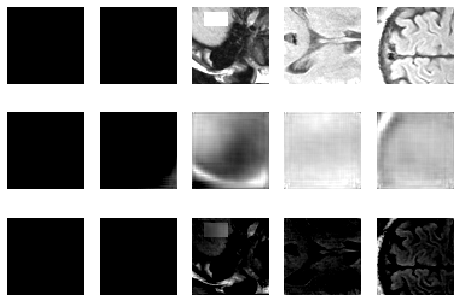

In [5]:
#model.load_model('gdrive/My Drive/tp_model.h5') 
import sklearn 
x_test_noisy=test_data.copy()
x_test_noisy[2,4:16,10:30,2] = 1
decoded_imgs = model.predict(x_test_noisy)
print(decoded_imgs.shape)
plt.figure()
for j in range(5):
  ax=plt.subplot(3, 5, j + 1)
  plt.imshow(x_test_noisy[j, :, :, 2].squeeze(), vmin=0., vmax=1., cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax=plt.subplot(3, 5, 5 + j + 1)
  plt.imshow(decoded_imgs[j, :, :, 2].squeeze(),vmin=0., vmax=1., cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax=plt.subplot(3, 5, 10 + j + 1)
  plt.imshow(x_test_noisy[j, :, :, 2].squeeze()-decoded_imgs[j, :, :, 2].squeeze(),vmin=0., vmax=1., cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  

plt.show()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mounted
8 (225, 225) JPEG
255
213.0
(35, 35)
(35, 35, 3)
(1, 35, 35, 3)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


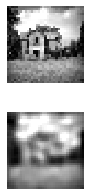

In [35]:
from google.colab import drive
import matplotlib.pyplot as plt
import sklearn 
from skimage.transform import resize
drive.mount('/content/gdrive')
print('mounted')
! pip install Pillow
from PIL import Image
im = Image.open( 'gdrive/My Drive/dataset/images.jpg' )
print(im.bits, im.size, im.format)
im = im.convert('L')
#im= im.convert('1') # convert image to black and white
import numpy as np
im = np.array(im)
p = np.max(np.ravel(im))  #normalize to 95 percentile
print(p)
p=np.percentile(np.ravel(im), 95)
print(p)
im=im/p
im = resize(im, (35, 35))
print(im.shape)
#arr = np.fromiter(iter(im.getdata()), np.uint8)
#arr.resize(im.height, im.width)
#print(arr.shape)
#plt.figure()
im_3chan=np.zeros((35,35,3))
print(im_3chan.shape)
im_3chan[:,:,0]=im
im_3chan[:,:,1]=1-im
im_3chan[:,:,2]=np.power(im,2)
im_3chan=im_3chan.reshape((1,35,35,3))


decoded_imgs = model.predict(im_3chan)
print(decoded_imgs.shape)
ax=plt.subplot(3, 5, 1)
plt.imshow(im, vmin=0., vmax=1., cmap='gray')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax=plt.subplot(3, 5, 1+5)
plt.imshow(decoded_imgs[0,:,:,0].squeeze(), vmin=0., vmax=1., cmap='gray')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [0]:
import keras.backend as K
def dice_coef(y_true, y_pred, smooth, thresh):
    y_pred = y_pred > thresh
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_loss(smooth, thresh):
    def dice(y_true, y_pred)
        return -dice_coef(y_true, y_pred, smooth, thresh)
    return dice
  model_dice = dice_loss(smooth=1e-5, thresh=0.5)+
  model.compile(loss=model_dice)